In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv004.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 simulation experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [4]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --n_layers {n_layers} \\
    --activ_fn {activ_fn} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{noise_ratio:.0e}_{savgol_filter}_{omega}_{pde_name}'

param_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    noise_ratio=[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    omega=[60],
    n_layers=[5],
    activ_fn=['ss'],
    savgol_filter=[0, 1],
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)

len(param_space)

144

In [5]:
name.format(**list(param_space)[0])

'train_fem_box_50_0e+00_0_60_helmholtz'

In [40]:
%autoreload

expt_name = '2023-2-24_sim_noise2'

#jobs = ps.submit(template, name, list(param_space), work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [41]:
%autoreload
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse_stdout=True, parse_stderr=True)
status[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
14688853,train_fem_box_50_0e+00_0_60_helmholtz,NaN,NaN,NaN,v031,
14688854,train_fem_box_50_0e+00_0_60_hetero,NaN,NaN,NaN,v030,
14688855,train_fem_box_50_0e+00_1_60_helmholtz,NaN,NaN,NaN,v022,
14688856,train_fem_box_50_0e+00_1_60_hetero,NaN,NaN,NaN,v020,
14688857,train_fem_box_50_1e-05_0_60_helmholtz,NaN,NaN,NaN,v026,
...,...,...,...,...,...,...
14688992,train_fem_box_100_1e-02_1_60_hetero,NaN,NaN,NaN,v032,
14688993,train_fem_box_100_1e-01_0_60_helmholtz,NaN,NaN,NaN,v003,
14688994,train_fem_box_100_1e-01_0_60_hetero,NaN,NaN,NaN,v005,


In [42]:
def get_error_type(e):
    for error_type in [
        'CANCELLED',
        'python: command not found',
        'Unexpected error from cudaGetDeviceCount()'
    ]:
        if error_type in e:
            return error_type
    return e

status['has_stderr_file'] = status.stderr.map(lambda x: not (isinstance(x, float) and np.isnan(x)))
status['has_stderr'] = ~status.stderr.isnull() & ~(status.stderr == '')
status['error'] = status.stderr.astype(str).map(get_error_type)

status.fillna('DONE').groupby(['job_state', 'has_stderr_file', 'has_stderr', 'error'])[['job_name']].count()

,,,,job_name
job_state,has_stderr_file,has_stderr,error,
DONE,True,False,,144


In [43]:
status[status.has_stderr].groupby(['error', 'stdout'])[['job_name']].count()

,,job_name
error,stdout,


In [44]:
metrics = ps.metrics(jobs)

# did all models train to completion?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id', 'noise_ratio', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric group columns
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric value columns

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

a_pred_MSAV  \
pde_name  example_id noise_ratio savgol_filter spatial_frequency_bin spatial_region                
helmholtz 50         0.0         0             all                   all                     0.0   
                                                                     1                       NaN   
                                                                     2                       NaN   
                                                                     3                       NaN   
                                                                     4                       NaN   
...                                                                                          ...   
hetero    100        0.1         1             6.0                   all                     NaN   
                                               7.0                   all                     NaN   
                                               8.0                   all                     NaN   
                                               9.0                   all                     NaN   
                                               10.0                  all                     NaN   

                                                                                     a_pred_MSAE  \
pde_name  example_id noise_ratio savgol_filter spatial_frequency_bin spatial_region                
helmholtz 50         0.0         0             all                   all                     0.0   
                                                                     1                       NaN   
                                                                     2                       NaN   
                                                                     3                       NaN   
                                                                     4                       NaN   
...                                                                                          ...   
hetero    100        0.1         1             6.0                   all                     NaN   
                                               7.0                   all                     NaN   
                                               8.0                   all                     NaN   
                                               9.0                   all                     NaN   
                                               10.0                  all                     NaN   

                                                                                     a_true_MSAV  \
pde_name  example_id noise_ratio savgol_filter spatial_frequency_bin spatial_region                
helmholtz 50         0.0         0             all                   all                     0.0   
                                                                     1                       NaN   
                                                                     2                       NaN   
                                                                     3                       NaN   
                                                                     4                       NaN   
...                                                                                          ...   
hetero    100        0.1         1             6.0                   all                     NaN   
                                               7.0                   all                     NaN   
                                               8.0                   all                     NaN   
                                               9.0                   all                     NaN   
                                               10.0                  all                     NaN   

                                                                                     u_pred_MSAV  \
pde_name  example_id noise_ratio savgol_filter spatial_frequency_bin spatial_regio

<IPython.core.display.Javascript object>


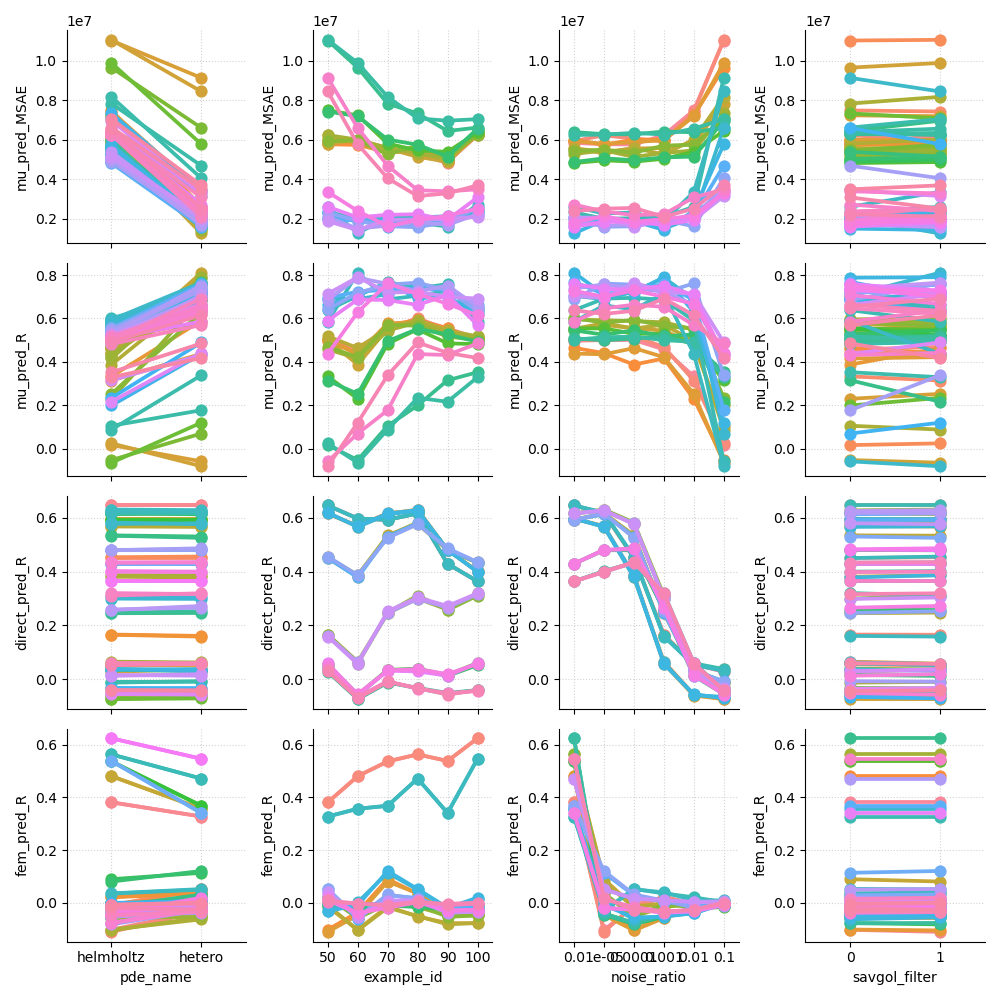

In [45]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')].copy(),
    x=param_cols,
    y=['mu_pred_MSAE', 'mu_pred_R', 'direct_pred_R', 'fem_pred_R'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [137]:
m['pde_abbrev'] = m.pde_name.map({'helmholtz': 'HH', 'hetero': 'het'}.__getitem__)
m['method'] = 'PINN-' + m['pde_abbrev']

ahi_m = m[m.pde_name == 'helmholtz'].copy()
ahi_m['method'] = 'AHI'
for col in m.columns:
    if col.startswith('direct'):
        ahi_m[col.replace('direct', 'mu')] = m[col]
        
fem_m = m.copy()
fem_m['method'] = 'FEM-' + m['pde_abbrev']
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([ahi_m, fem_m, m])

method_order = ['AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het']
region_order = ['all', '1', '2', '3', '4', '5']
mm['method_index'] = mm['method'].map(method_order.index)
mm['region_index'] = mm['spatial_region'].map(region_order.index)
mm = mm.sort_values(['method_index', 'region_index'])

In [138]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV'] * 100

In [139]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [red, yellow, green, cyan, blue]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

<IPython.core.display.Javascript object>


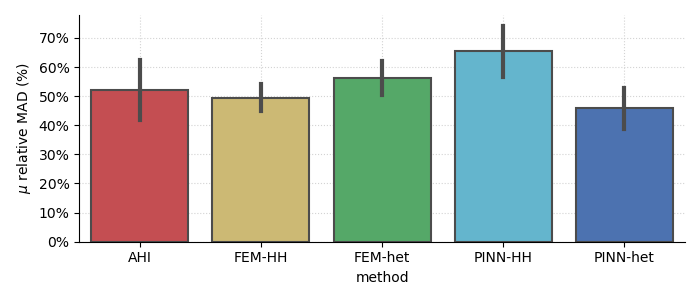

In [140]:
import matplotlib as mpl

fig = ps.plot(
    mm[
        (mm.spatial_frequency_bin == 'all') &
        (mm.noise_ratio == 0.0) &
        ~mm.savgol_filter
    ].copy(),
    x='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    tight=True,
    legend=False,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i%len(colors)])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [141]:
mm[
    (mm.spatial_region != 'all') &
    (mm.noise_ratio == 0.0) &
    ~mm.savgol_filter
].groupby(['method'])[['mu_pred_MAD_relative']].describe()

mu_pred_MAD_relative                                              \
                        count       mean        std        min        25%   
method                                                                      
AHI                      30.0  52.138892  30.582165   6.464485  19.596435   
FEM-HH                   30.0  49.444693  13.943769  25.031245  38.504028   
FEM-het                  30.0  56.349154  17.059764  24.273328  43.235177   
PINN-HH                  30.0  65.624415  25.534887  17.066152  63.408148   
PINN-het                 30.0  45.882514  19.961549  13.259699  32.355035   

                                            
                50%        75%         max  
method                                      
AHI       65.875894  71.935369  103.329509  
FEM-HH    49.086360  58.463774   78.105472  
FEM-het   59.661668  69.756955   85.206215  
PINN-HH   69.411755  77.919801  106.172179  
PINN-het  48.776573  62.391329   81.511410

<IPython.core.display.Javascript object>


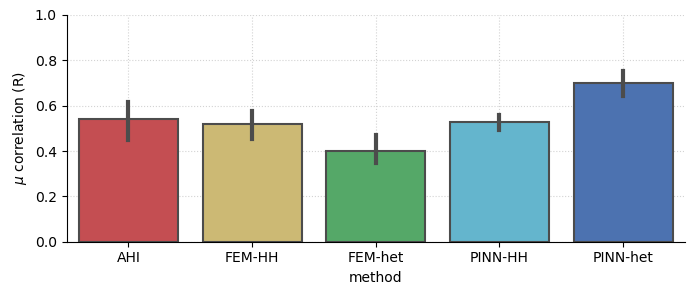

In [142]:
fig = ps.plot(
    mm[
        (mm.spatial_region == 'all') &
        (mm.spatial_frequency_bin == 'all') &
        (mm.noise_ratio == 0.0) &
        ~mm.savgol_filter
    ].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [143]:
mm[
    (mm.spatial_region == 'all') &
    (mm.spatial_frequency_bin == 'all') &
    (mm.noise_ratio == 0.0) &
    ~mm.savgol_filter
].groupby(['method'])[['mu_pred_R']].describe()

mu_pred_R                                                    \
             count      mean       std       min       25%       50%   
method                                                                 
AHI            6.0  0.540157  0.114912  0.363666  0.469514  0.594084   
FEM-HH         6.0  0.520270  0.082537  0.381062  0.494133  0.536975   
FEM-het        6.0  0.401579  0.087360  0.327193  0.344540  0.362275   
PINN-HH        6.0  0.527878  0.046740  0.464874  0.499946  0.527807   
PINN-het       6.0  0.698761  0.072817  0.585499  0.654570  0.720973   

                              
               75%       max  
method                        
AHI       0.610758  0.644800  
FEM-HH    0.556485  0.623765  
FEM-het   0.445254  0.546190  
PINN-HH   0.552445  0.595460  
PINN-het  0.753250  0.768675

In [144]:
[c for c in mm if c.startswith('mu')]

['mu_pred_MSAE',
 'mu_pred_MSAV',
 'mu_true_MSAV',
 'mu_diff_PSD',
 'mu_pred_PSD',
 'mu_true_PSD',
 'mu_pred_MAD',
 'mu_pred_MAV',
 'mu_true_MAV',
 'mu_diff_R',
 'mu_pred_R',
 'mu_true_R',
 'mu_pred_MSAE_relative',
 'mu_pred_MAD_relative']

In [198]:
# contrast metrics
mmm = mm[
    (mm.spatial_frequency_bin == 'all') &
    (mm.spatial_region != 'all')
]
regions = mmm.spatial_region.unique()
mmm = mmm.set_index(index_cols[2:] + param_cols + ['method'])
mmm = mmm.unstack(level=0)
for r in regions:
    mmm['mu_pred_MAC', r] = mmm['mu_pred_MAV', r] - mmm['mu_pred_MAV', '1']
    mmm['mu_true_MAC', r] = mmm['mu_true_MAV', r] - mmm['mu_true_MAV', '1']

mmm = mmm.stack().reset_index().sort_values(['method_index', 'region_index'])
mmm['mu_pred_CTE'] = mmm['mu_pred_MAC'] / mmm['mu_true_MAC'] * 100
mmm

,pde_name,example_id,noise_ratio,savgol_filter,method,spatial_region,Lu_true_MAV,Lu_true_MSAV,Lu_true_PSD,Lu_true_R,...,u_pred_MAV,u_pred_MSAE,u_pred_MSAV,u_pred_PSD,u_pred_R,u_true_MAV,u_true_MSAV,u_true_PSD,u_true_R,mu_pred_CTE
0,helmholtz,50,0.00000,0,AHI,1,30.129231,NaN,NaN,NaN,...,0.001412,NaN,NaN,NaN,NaN,0.001413,NaN,NaN,NaN,NaN
15,helmholtz,50,0.00000,1,AHI,1,30.129231,NaN,NaN,NaN,...,0.001413,NaN,NaN,NaN,NaN,0.001413,NaN,NaN,NaN,NaN
30,helmholtz,50,0.00001,0,AHI,1,51.835527,NaN,NaN,NaN,...,0.001411,NaN,NaN,NaN,NaN,0.001413,NaN,NaN,NaN,NaN
45,helmholtz,50,0.00001,1,AHI,1,51.807668,NaN,NaN,NaN,...,0.001412,NaN,NaN,NaN,NaN,0.001412,NaN,NaN,NaN,NaN
60,helmholtz,50,0.00010,0,AHI,1,127.715910,NaN,NaN,NaN,...,0.001414,NaN,NaN,NaN,NaN,0.001418,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,hetero,100,0.00100,1,PINN-het,5,100.709811,NaN,NaN,NaN,...,0.000175,NaN,NaN,NaN,NaN,0.000187,NaN,NaN,NaN,2.373984
1769,hetero,100,0.01000,0,PINN-het,5,245.107672,NaN,NaN,NaN,...,0.000158,NaN,NaN,NaN,NaN,0.000321,NaN,NaN,NaN,1.646036
1779,hetero,100,0.01000,1,PINN-het,5,223.788004,NaN,NaN,NaN,...,0.000182,NaN,NaN,NaN,NaN,0.000339,NaN,NaN,NaN,-2.855406
1789,hetero,100,0.10000,0,PINN-het,5,604.407490,NaN,NaN,NaN,...,0.000184,NaN,NaN,NaN,NaN,0.000795,NaN,NaN,NaN,6.080382


In [199]:
mmm[['mu_pred_MAC', 'mu_true_MAC', 'mu_pred_CTE']]

,mu_pred_MAC,mu_true_MAC,mu_pred_CTE
0,0.000000,0.000000,NaN
15,0.000000,0.000000,NaN
30,0.000000,0.000000,NaN
45,0.000000,0.000000,NaN
60,0.000000,0.000000,NaN
...,...,...,...
1759,165.101798,6954.628547,2.373984
1769,114.475663,6954.628547,1.646036
1779,-198.582869,6954.628547,-2.855406
1789,422.867950,6954.628547,6.080382


<IPython.core.display.Javascript object>


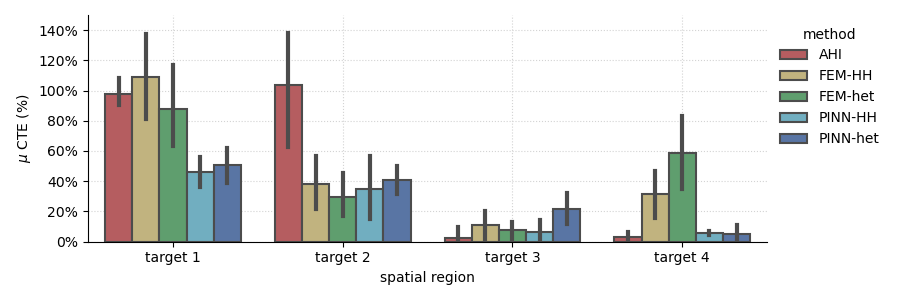

In [202]:
fig = ps.plot(
    mmm[
        (mmm.spatial_region.isin(set('2345'))) &
        (mmm.noise_ratio == 0.0) &
        ~mmm.savgol_filter
    ],
    x='spatial_region',
    y='mu_pred_CTE',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylim(0, 150)
fig.axes[0].set_ylabel('$\mu$ CTE (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_contrast_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [235]:
mmm[
    (mmm.spatial_region.isin(set('2345'))) &
    (mmm.noise_ratio == 0.0) &
    ~mmm.savgol_filter
].groupby(['spatial_region', 'method'])[['mu_pred_CTE']].describe()

mu_pred_CTE                                    \
                              count        mean        std        min   
spatial_region method                                                   
2              AHI              6.0   97.790984  12.070345  86.385616   
               FEM-HH           6.0  108.929942  39.192674  59.556060   
               FEM-het          6.0   87.547481  37.157222  53.657147   
               PINN-HH          6.0   46.301104  14.043387  24.771183   
               PINN-het         6.0   50.910568  16.094744  28.491055   
3              AHI              6.0  103.577800  52.748358  17.200685   
               FEM-HH           6.0   37.899849  23.108028   6.896111   
               FEM-het          6.0   29.541100  20.082345  11.435213   
               PINN-HH          6.0   35.117533  30.698264  -8.616966   
               PINN-het         6.0   40.561392  13.029750  20.949503   
4              AHI              6.0    2.263904  11.430769 -16.713850   
               FEM-HH           6.0   11.006844  13.572295  -8.708746   
               FEM-het          6.0    7.596822   7.646053  -3.557680   
               PINN-HH          6.0    6.630961  10.134908  -9.702047   
               PINN-het         6.0   21.788831  14.541401   2.044075   
5              AHI              6.0    2.745962   4.545525  -1.165654   
               FEM-HH           6.0   31.695367  21.993986   0.428804   
               FEM-het          6.0   58.789850  33.726262  19.112321   
               PINN-HH          6.0    5.636470   1.743829   3.312352   
               PINN-het         6.0    4.762020   9.006492  -8.403026   

                                                                        
                               25%         50%         75%         max  
spatial_region method                                                   
2              AHI       90.003452   94.022825  102.034785  118.945535  
               FEM-HH    80.181085  111.219947  130.691343  164.567089  
               FEM-het   61.448250   80.869108   95.470679  154.577021  
               PINN-HH   39.723753   46.129068   56.637160   63.048798  
               PINN-het  39.962591   52.971099   63.423022   68.496739  
3              AHI       77.561858  116.383852  144.130822  153.497406  
               FEM-HH    27.449588   36.043296   44.890447   75.991876  
               FEM-het   13.715927   26.409845   36.548741   63.578702  
               PINN-HH   14.159644   40.497941   57.456516   69.836695  
               PINN-het  33.042727   43.388641   48.162752   56.293355  
4              AHI       -3.180614    6.467849    8.813417   14.163071  
               FEM-HH     1.688756   14.977342   19.861214   26.046728  
               FEM-het    3.439900    8.531646   11.119727   18.350249  
               PINN-HH    4.868240    6.994312    8.817522   21.914378  
               PINN-het  10.071556   28.768149   32.405468   33.695348  
5              AHI        0.105521    1.884571    2.635651   11.473766  
               FEM-HH    15.217544   40.194057   47.259396   52.848733  
               FEM-het   35.715443   60.538797   68.305345  114.213999  
               PINN-HH    4.801098    5.382717    6.420391    8.367526  
               PINN-het  -1.486953    9.077224   10.733153   12.543917

<IPython.core.display.Javascript object>


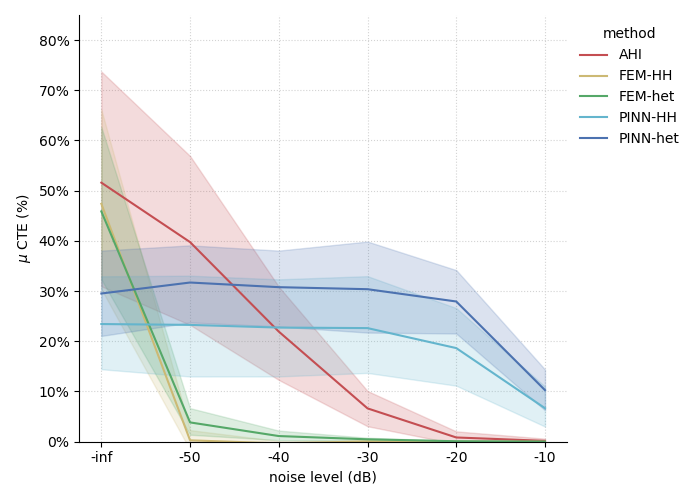

In [237]:
fig = ps.plot(
    mmm[mmm.spatial_region.isin(set('2345')) & ~mmm.savgol_filter],
    x='noise_level',
    y='mu_pred_CTE',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
ax[0,1].set_xlabel('noise level (dB)')
ax[0,1].set_xticks([-60, -50, -40, -30, -20, -10])
ax[0,1].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

fig.axes[0].set_ylabel('$\mu$ CTE (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 85)
fig.tight_layout()

fig.axes[0].set_xlabel('noise level (dB)')
fig.axes[0].set_xticks([-60, -50, -40, -30, -20, -10])
fig.axes[0].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_CTE_plot.{ext}', bbox_inches='tight', dpi=200)

In [238]:
mmm[
    mmm.spatial_region.isin(set('2345')) & ~mmm.savgol_filter
].groupby(['method', 'noise_level'])[['mu_pred_CTE']].describe()

mu_pred_CTE                                              \
                           count       mean        std        min        25%   
method   noise_level                                                           
AHI      -60.0              24.0  51.594662  56.466007 -16.713850   2.635651   
         -50.0              24.0  39.745914  43.075296 -14.344950   3.468391   
         -40.0              24.0  21.911516  24.616176  -9.791818   1.673378   
         -30.0              24.0   6.614186   9.157041  -9.332295   0.615886   
         -20.0              24.0   0.818476   3.196871  -5.242409  -1.017765   
         -10.0              24.0   0.144442   1.111623  -2.064324  -0.511847   
FEM-HH   -60.0              24.0  47.383000  44.902621  -8.708746  16.038457   
         -50.0              24.0   0.249679   5.152029 -10.160486  -2.658329   
         -40.0              24.0  -0.355787   1.127511  -2.533070  -1.231113   
         -30.0              24.0   0.039662   0.336024  -0.677492  -0.228559   
         -20.0              24.0  -0.010543   0.062555  -0.145651  -0.049851   
         -10.0              24.0  -0.022309   0.047609  -0.148231  -0.051744   
FEM-het  -60.0              24.0  45.868813  39.952057  -3.557680  12.352404   
         -50.0              24.0   3.819079   6.885788  -5.239619  -1.216633   
         -40.0              24.0   1.101453   2.378076  -3.082785   0.043516   
         -30.0              24.0   0.451497   0.847374  -1.083401   0.015712   
         -20.0              24.0   0.066283   0.191185  -0.263240  -0.049968   
         -10.0              24.0   0.000811   0.043544  -0.065378  -0.026467   
PINN-HH  -60.0              24.0  23.421517  24.475191  -9.702047   5.431909   
         -50.0              24.0  23.250988  25.293136 -11.955924   5.828675   
         -40.0              24.0  22.715490  24.399642  -9.406831   5.487753   
         -30.0              24.0  22.612006  24.420910 -10.816957   3.947921   
         -20.0              24.0  18.628033  20.430843 -13.897308   5.980670   
         -10.0              24.0   6.649149   9.934219 -12.412997   0.148555   
PINN-het -60.0              24.0  29.505703  21.988239  -8.403026  10.733153   
         -50.0              24.0  31.695131  19.891137  -7.323998  13.179861   
         -40.0              24.0  30.767850  19.627813  -8.269604  14.191084   
         -30.0              24.0  30.363409  22.483253  -9.597801  11.525378   
         -20.0              24.0  27.913060  16.850371  -8.988532  12.938610   
         -10.0              24.0  10.250717  10.284477  -5.971376   4.561595   

                                                        
                            50%        75%         max  
method   noise_level                                    
AHI      -60.0        15.681878  98.250940  153.497406  
         -50.0        12.734066  72.506382  124.529209  
         -40.0        12.445724  41.168756   76.096459  
         -30.0         3.247031  13.114796   28.258627  
         -20.0        -0.119299   2.006535    7.589069  
         -10.0        -0.117007   0.845278    2.576926  
FEM-HH   -60.0        36.897571  62.628693  164.567089  
         -50.0        -1.167490   1.945469   12.621778  
         -40.0        -0.320204   0.701276    1.809569  
         -30.0         0.012624   0.255335    0.725342  
         -20.0        -0.015608   0.042648    0.090396  
         -10.0        -0.020662  -0.000535    0.071939  
FEM-het  -60.0        36.219289  67.666117  154.577021  
         -50.0         1.808169   6.242694   21.349220  
         -40.0         0.845289   1.750239    8.925142  
         -30.0         0.362744   1.063632    2.095523  
         -20.0         0.030489   0.248089    0.388905  
         -10.0        -0.005121   0.011701    0.132096  
PINN-HH  -60.0         9.298668  44.401830   69.836695  
         -50.0         9.048979  44.054521   73.433867  
         -40.0        10.148135  42.735891   77.619776  
         -30

In [255]:
# two-sample t tests
from scipy.stats import ttest_ind, ttest_rel

for method, df in mmm[
    mmm.spatial_region.isin(set('2345')) & ~mmm.savgol_filter
].groupby('method'):
    print(method)
    df = df.set_index(['example_id', 'spatial_region'])
    sample1 = df[df.noise_level == -60]
    for ndb in [-50, -40, -30, -20, -10]:
        sample2 = df[df.noise_level == ndb]
        res = ttest_rel(sample2.mu_pred_CTE, sample1.mu_pred_CTE, alternative='less')
        print(ndb, res)


AHI
-50 Ttest_relResult(statistic=-3.6831001366170355, pvalue=0.000615718333184049)
-40 Ttest_relResult(statistic=-4.215398903877769, pvalue=0.00016458001065866216)
-30 Ttest_relResult(statistic=-4.435493154127543, pvalue=9.506488440987507e-05)
-20 Ttest_relResult(statistic=-4.494565193267231, pvalue=8.203982339987766e-05)
-10 Ttest_relResult(statistic=-4.469388553400962, pvalue=8.735727641606034e-05)
FEM-HH
-50 Ttest_relResult(statistic=-5.131487387175304, pvalue=1.6842561764556174e-05)
-40 Ttest_relResult(statistic=-5.152522971519955, pvalue=1.598952984516903e-05)
-30 Ttest_relResult(statistic=-5.144855868094972, pvalue=1.629527024781466e-05)
-20 Ttest_relResult(statistic=-5.16633109255666, pvalue=1.5453445770117206e-05)
-10 Ttest_relResult(statistic=-5.17144802082538, pvalue=1.5259431193151796e-05)
FEM-het
-50 Ttest_relResult(statistic=-5.3808867246409084, pvalue=9.11225767575716e-06)
-40 Ttest_relResult(statistic=-5.373568957631742, pvalue=9.277392072226225e-06)
-30 Ttest_relResult

<IPython.core.display.Javascript object>


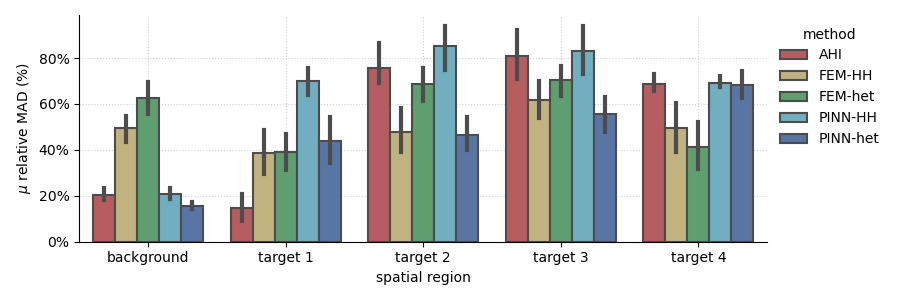

In [203]:
fig = ps.plot(
    mm[
        (mm.spatial_region != 'all') &
        (mm.noise_ratio == 0.0) &
        ~mm.savgol_filter
    ],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_region_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


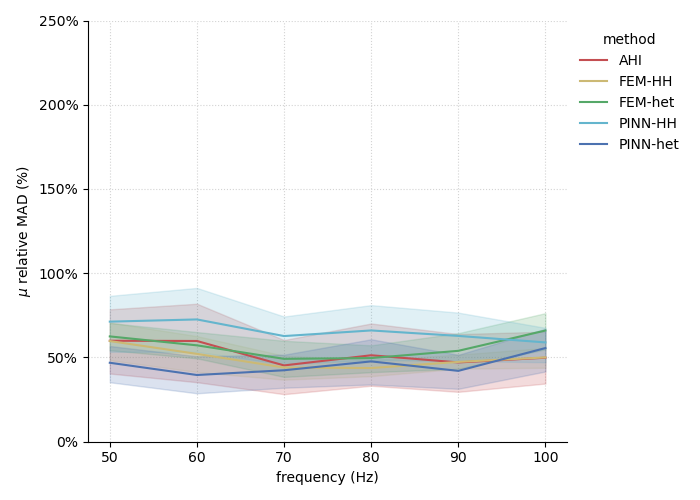

In [74]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 250)
fig.tight_layout()

fig.axes[0].set_xlabel('frequency (Hz)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_frequency_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [75]:
mm['noise_level'] = 10 * np.log10(mm['noise_ratio'])
mm.loc[np.isinf(mm.noise_level), 'noise_level'] = -60

  result = getattr(ufunc, method)(*inputs, **kwargs)



<IPython.core.display.Javascript object>


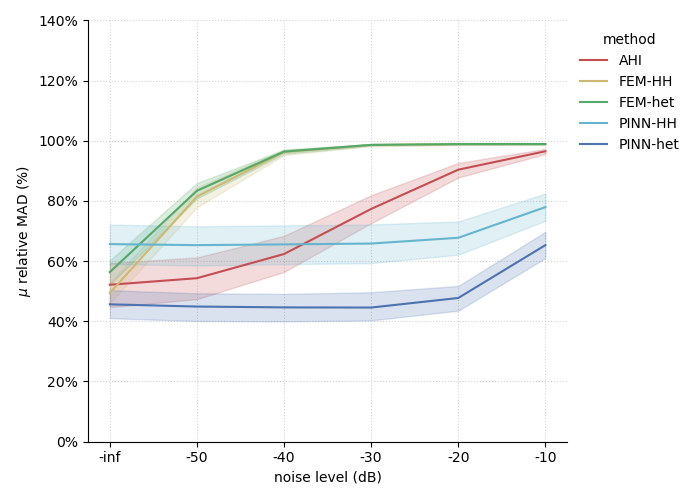

In [76]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all')],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 140)
fig.tight_layout()

fig.axes[0].set_xlabel('noise level (dB)')
fig.axes[0].set_xticks([-60, -50, -40, -30, -20, -10])
fig.axes[0].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [97]:
mm[
    (mm.spatial_region != 'all') &
    ~mm.savgol_filter
].groupby(['method', 'noise_level'])[['mu_pred_MAD_relative']].describe()

mu_pred_MAD_relative                                   \
                                    count       mean        std        min   
method   noise_level                                                         
AHI      -60.0                       30.0  52.138892  30.582165   6.464485   
         -50.0                       30.0  54.375361  27.984106  16.258850   
         -40.0                       30.0  62.475131  24.067502  19.074933   
         -30.0                       30.0  77.399151  19.005485  33.938863   
         -20.0                       30.0  90.404184   9.421328  64.703560   
         -10.0                       30.0  96.550963   3.431239  85.495810   
FEM-HH   -60.0                       30.0  49.444693  13.943769  25.031245   
         -50.0                       30.0  81.461496  12.984962  50.979723   
         -40.0                       30.0  96.241332   3.518605  87.035854   
         -30.0                       30.0  98.591200   1.185899  94.665915   
         -20.0                       30.0  98.856830   0.937544  95.689199   
         -10.0                       30.0  98.901213   0.908253  95.843453   
FEM-het  -60.0                       30.0  56.349154  17.059764  24.273328   
         -50.0                       30.0  83.335296  10.453901  62.360448   
         -40.0                       30.0  96.423935   2.883565  89.195151   
         -30.0                       30.0  98.667028   1.042455  95.360769   
         -20.0                       30.0  98.911902   0.873242  95.978018   
         -10.0                       30.0  98.933386   0.863499  96.042457   
PINN-HH  -60.0                       30.0  65.624415  25.534887  17.066152   
         -50.0                       30.0  65.173932  25.098298  17.244628   
         -40.0                       30.0  65.452222  25.183086  18.052194   
         -30.0                       30.0  65.669625  24.894254  18.731261   
         -20.0                       30.0  67.893086  23.191092  22.980933   
         -10.0                       30.0  77.540607  18.384683  33.716075   
PINN-het -60.0                       30.0  45.882514  19.961549  13.259699   
         -50.0                       30.0  44.382651  18.294020  12.527147   
         -40.0                       30.0  44.465701  18.439235  12.485081   
         -30.0                       30.0  44.855791  19.551232  12.800080   
         -20.0                       30.0  47.717995  17.358551  16.309211   
         -10.0                       30.0  66.479927  18.421758  24.733514   

                                                                   
                            25%        50%        75%         max  
method   noise_level                                               
AHI      -60.0        19.596435  65.875894  71.935369  103.329509  
         -50.0        22.235944  66.071253  71.490693  103.341829  
         -40.0        45.590207  69.541674  76.563920  101.769995  
         -30.0        76.309250  80.080594  91.440775  102.661275  
         -20.0        89.743211  92.128597  96.568284  100.690668  
         -10.0        95.941968  97.226708  98.760257  100.195112  
FEM-HH   -60.0        38.504028  49.086360  58.463774   78.105472  
         -50.0        77.497401  85.427275  90.737015   94.909913  
         -40.0        96.471317  97.363345  98.328879   99.439410  
         -30.0        98.508555  98.944106  99.329434   99.627757  
         -20.0        98.731973  99.128735  99.471826   99.668367  
         -10.0        98.754895  99.153590  99.475205   99.702046  
FEM-het  -60.0        43.235177  59.661668  69.756955   85.206215  
         -50.0        79.076688  86.606255  90.418144   96.692513  
         -40.0        95.338775  96.854001  98.450507   99.950169  
         -30.0        98.432233  98.811718  99.331449   99.815939  
         -20.0        98.754500  99.089804  99.519227   99.703072  
         -10.0        98.768947  99.168746  99.503564   99.732299  
PINN-HH  -60.0    

<IPython.core.display.Javascript object>


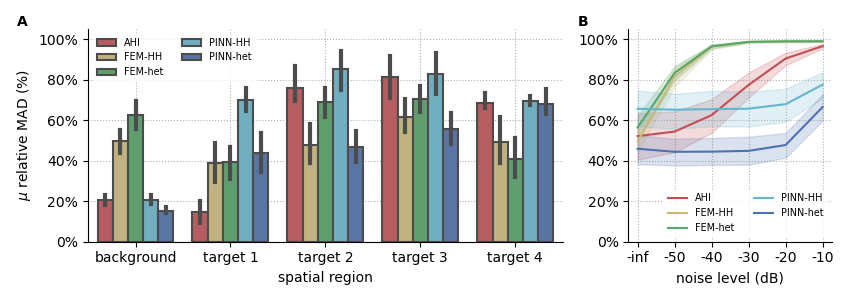

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

ps.results.barplot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0) & ~mm.savgol_filter],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)
ax[0,0].legend(frameon=True, edgecolor='w', loc='upper left', fontsize='x-small', ncol=2)

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('$\mu$ relative MAD (%)')
ax[0,0].set_ylim(0, 105)
ax[0,0].yaxis.set_major_formatter(pct_format)

ax[0,0].set_xlabel('spatial region')
ax[0,0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

sns.lineplot(
    mm[(mm.spatial_region != 'all') & ~mm.savgol_filter],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    ax=ax[0,1]
)
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)
ax[0,1].legend(frameon=True, edgecolor='w', fontsize='x-small', ncol=2, loc='lower right')

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel(None)
ax[0,1].set_ylim(0, 105)
ax[0,1].yaxis.set_major_formatter(pct_format)

ax[0,1].set_xlabel('noise level (dB)')
ax[0,1].set_xticks([-60, -50, -40, -30, -20, -10])
ax[0,1].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_plots.{ext}', bbox_inches='tight', dpi=200)

In [90]:
mm[
    (mm.spatial_region != 'all') &
    (mm.noise_ratio == 0.0) &
    ~mm.savgol_filter
].groupby(['method', 'spatial_region'])[['mu_pred_MAD_relative']].describe()

mu_pred_MAD_relative                                   \
                                       count       mean        std        min   
method   spatial_region                                                         
AHI      1                               6.0  20.477379   3.751072  16.015281   
         2                               6.0  14.519883   8.086173   6.464485   
         3                               6.0  75.880400  12.898376  67.540044   
         4                               6.0  81.106068  15.260826  65.378939   
         5                               6.0  68.710727   5.640336  65.196416   
FEM-HH   1                               6.0  49.713624   8.056941  39.419135   
         2                               6.0  38.721534  13.555974  25.031245   
         3                               6.0  47.626957  13.319063  35.532191   
         4                               6.0  61.798584  11.477178  52.424220   
         5                               6.0  49.362768  15.642861  36.433334   
FEM-het  1                               6.0  62.508070   9.471102  50.431559   
         2                               6.0  39.107324  10.769252  24.273328   
         3                               6.0  68.825879  10.441744  55.005888   
         4                               6.0  70.264800   9.064502  58.560028   
         5                               6.0  41.039698  13.727527  26.411800   
PINN-HH  1                               6.0  20.622503   3.365510  17.066152   
         2                               6.0  70.151009   8.281760  60.348371   
         3                               6.0  85.056447  13.746974  68.585661   
         4                               6.0  82.933703  14.733485  68.196449   
         5                               6.0  69.358410   3.409311  66.886762   
PINN-het 1                               6.0  15.404354   2.302428  13.259699   
         2                               6.0  43.890692  13.766344  27.153052   
         3                               6.0  46.546780  10.190588  33.164196   
         4                               6.0  55.423368  10.917623  46.014233   
         5                               6.0  68.147377   8.314880  62.284322   

                                                                      
                               25%        50%        75%         max  
method   spatial_region                                               
AHI      1               18.651430  19.654685  21.611978   26.958204  
         2                9.367848  12.235311  17.634529   28.337897  
         3               69.426491  72.059835  72.960188  101.813668  
         4               68.720082  78.808711  90.917179  103.329509  
         5               65.705036  66.380598  68.273767   79.922081  
FEM-HH   1               43.278905  50.775084  55.943344   58.866166  
         2               29.515436  35.662840  44.090980   61.605617  
         3               37.279142  45.243418  52.103181   70.728564  
         4               53.018843  56.633862  70.543653   78.105472  
         5               38.813813  41.551845  60.188639   72.337547  
FEM-het  1               55.690319  62.281703  69.722146   74.357968  
         2               32.167555  40.873833  43.910248   54.435103  
         3               62.736785  69.390377  72.430215   85.206215  
         4               63.134509  71.293553  78.226154   79.489815  
         5               33.545232  35.922303  48.068781   63.111302  
PINN-HH  1               18.961143  20.152706  20.722231   26.887427  
         2               63.408148  70.331339  77.516232   78.883393  
         3               76.192876  83.870687  91.622067  106.172179  
         4               71.961522  79.273850  91.265160  106.071729  
         5               67.170664  68.195360  69.660731   75.894694  
PINN-het 1               14.338656  14.666118  15.513686   19.808476  
         2               33.211798  43.741775  54.7

mu_pred_MAD_relative                                   \
                                    count       mean        std        min   
method   noise_ratio                                                         
AHI      0.00000                     30.0  52.138892  30.582165   6.464485   
         0.00001                     30.0  54.375361  27.984106  16.258850   
         0.00010                     30.0  62.475131  24.067502  19.074933   
         0.00100                     30.0  77.399151  19.005485  33.938863   
         0.01000                     30.0  90.404184   9.421328  64.703560   
         0.10000                     30.0  96.550963   3.431239  85.495810   
FEM-HH   0.00000                     30.0  49.444693  13.943769  25.031245   
         0.00001                     30.0  81.461496  12.984962  50.979723   
         0.00010                     30.0  96.241332   3.518605  87.035854   
         0.00100                     30.0  98.591200   1.185899  94.665915   
         0.01000                     30.0  98.856830   0.937544  95.689199   
         0.10000                     30.0  98.901213   0.908253  95.843453   
FEM-het  0.00000                     30.0  56.349154  17.059764  24.273328   
         0.00001                     30.0  83.335296  10.453901  62.360448   
         0.00010                     30.0  96.423935   2.883565  89.195151   
         0.00100                     30.0  98.667028   1.042455  95.360769   
         0.01000                     30.0  98.911902   0.873242  95.978018   
         0.10000                     30.0  98.933386   0.863499  96.042457   
PINN-HH  0.00000                     30.0  65.624415  25.534887  17.066152   
         0.00001                     30.0  65.173932  25.098298  17.244628   
         0.00010                     30.0  65.452222  25.183086  18.052194   
         0.00100                     30.0  65.669625  24.894254  18.731261   
         0.01000                     30.0  67.893086  23.191092  22.980933   
         0.10000                     30.0  77.540607  18.384683  33.716075   
PINN-het 0.00000                     30.0  45.882514  19.961549  13.259699   
         0.00001                     30.0  44.382651  18.294020  12.527147   
         0.00010                     30.0  44.465701  18.439235  12.485081   
         0.00100                     30.0  44.855791  19.551232  12.800080   
         0.01000                     30.0  47.717995  17.358551  16.309211   
         0.10000                     30.0  66.479927  18.421758  24.733514   

                                                                   
                            25%        50%        75%         max  
method   noise_ratio                                               
AHI      0.00000      19.596435  65.875894  71.935369  103.329509  
         0.00001      22.235944  66.071253  71.490693  103.341829  
         0.00010      45.590207  69.541674  76.563920  101.769995  
         0.00100      76.309250  80.080594  91.440775  102.661275  
         0.01000      89.743211  92.128597  96.568284  100.690668  
         0.10000      95.941968  97.226708  98.760257  100.195112  
FEM-HH   0.00000      38.504028  49.086360  58.463774   78.105472  
         0.00001      77.497401  85.427275  90.737015   94.909913  
         0.00010      96.471317  97.363345  98.328879   99.439410  
         0.00100      98.508555  98.944106  99.329434   99.627757  
         0.01000      98.731973  99.128735  99.471826   99.668367  
         0.10000      98.754895  99.153590  99.475205   99.702046  
FEM-het  0.00000      43.235177  59.661668  69.756955   85.206215  
         0.00001      79.076688  86.606255  90.418144   96.692513  
         0.00010      95.338775  96.854001  98.450507   99.950169  
         0.00100      98.432233  98.811718  99.331449   99.815939  
         0.01000      98.754500  99.089804  99.519227   99.703072  
         0.10000      98.768947  99.168746  99.503564   99.732299  
PINN-HH  0.00000  

In [206]:
mmm['noise_level'] = 10 * np.log10(mmm['noise_ratio'])
mmm.loc[np.isinf(mmm.noise_level), 'noise_level'] = -60

  result = getattr(ufunc, method)(*inputs, **kwargs)



<IPython.core.display.Javascript object>


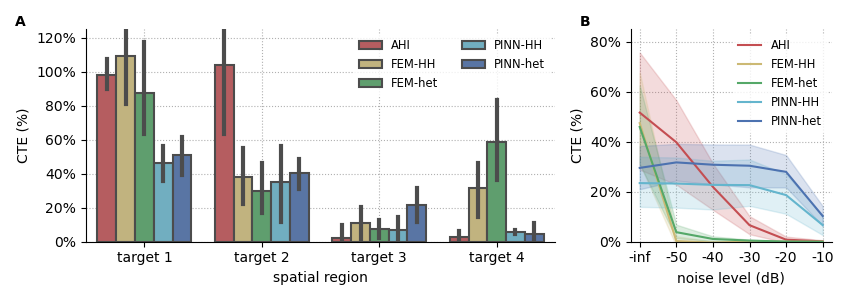

In [256]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

ps.results.barplot(
    mmm[mmm.spatial_region.isin(set('2345')) & (mmm.noise_ratio == 0.0) & ~mmm.savgol_filter],
    x='spatial_region',
    y='mu_pred_CTE',
    hue='method',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)
ax[0,0].legend(frameon=True, edgecolor='w', loc='upper right', fontsize='small', ncol=2)

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('CTE (%)')
ax[0,0].set_ylim(0, 125)
ax[0,0].yaxis.set_major_formatter(pct_format)

ax[0,0].set_xlabel('spatial region')
ax[0,0].set_xticklabels(['target 1', 'target 2', 'target 3', 'target 4'])

sns.lineplot(
    mmm[mmm.spatial_region.isin(set('2345')) & ~mmm.savgol_filter],
    x='noise_level',
    y='mu_pred_CTE',
    hue='method',
    ax=ax[0,1]
)
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)
ax[0,1].legend(frameon=True, edgecolor='w', fontsize='small', ncol=1, loc='upper right')

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel('CTE (%)')
ax[0,1].set_ylim(0, 85)
ax[0,1].yaxis.set_major_formatter(pct_format)

ax[0,1].set_xlabel('noise level (dB)')
ax[0,1].set_xticks([-60, -50, -40, -30, -20, -10])
ax[0,1].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_contrast_plots.{ext}', bbox_inches='tight', dpi=200)

In [82]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue,
    purple=purple
)

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc


<IPython.core.display.Javascript object>


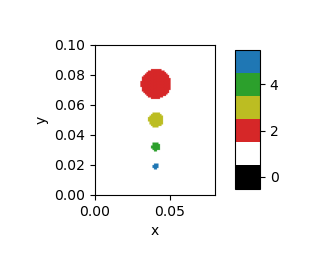

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


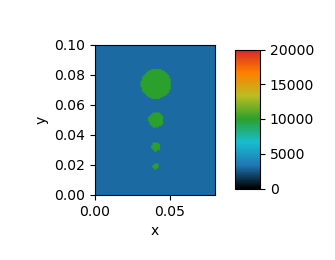

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [83]:
wave_kws = dict(vmin=-1e-2, vmax=1e-2, cmap=mre_pinn.visual.wave_color_map())
elast_kws = dict(vmin=0, vmax=20e3, cmap=mre_pinn.visual.mre_color_map(symmetric=False))

dataset = mre_pinn.data.MREDataset.load_xarrays(
    xarray_dir='../data/BIOQIC/fem_box'
)
dataset[0].view('mre_mask', ax_height=1.5, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_regions.png', dpi=200, bbox_inches='tight')
dataset[0].view('mre', ax_height=1.5, space=0.2, **elast_kws)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


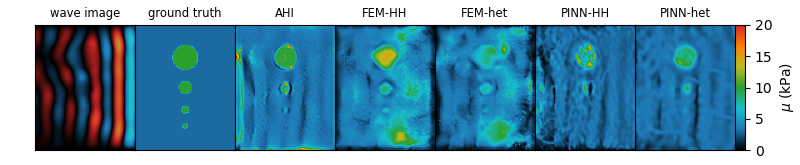

Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_direct.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_fem.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_hetero/train_fem_box_90_0e+00_0_60_hetero_fem.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_elastogram.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_hetero/train_fem_box_90_0e+00_0_60_hetero_elastogram.nc


In [303]:
%autoreload
import mre_pinn

# image grid

image_names = [
    'wave image', 'ground truth', 'AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het'
]

expt_name = '2023-2-24_sim_noise2' 
name = 'train_fem_box_{example_id}_{noise_ratio:.0e}_{savgol_filter}_{omega}_{pde_name}'

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    cbar_width = 0.1
    
    noise_ratio = 0
    savgol_filter = 0
    omega = 60

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(
        n_rows, n_cols, ax_height, ax_width, cbar_width, space=0, pad=(0.35,0.55,0.15,0.25)
    )
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0 and False:
                ax.set_ylabel(example_id + ' Hz', fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])
            
            if image_name == 'regions':
                array = example.mre_mask.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)

            elif image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = wave_kws
                array = array.real

            elif image_name in {'ground truth', 'elastogram'}:
                array = example.mre.sel(z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'AHI':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)
                
            elif image_name == 'FEM-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'FEM-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            im = mre_pinn.visual.imshow(ax, array, **color_kws)
            
    plt.colorbar(im, cax=cbar_ax)
    cbar_ax.set_yticks([0, 5e3, 10e3, 15e3, 20e3])
    cbar_ax.set_yticklabels(['0', '5', '10', '15', '20'])
    cbar_ax.set_ylabel('$\mu$ (kPa)')
            
    return fig

fig = plot_image_grid(['90']) #['50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['50', '60', '70'])
#fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_wave_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/fem_box_wave_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/fem_box_wave_grid1.{ext}', bbox_inches='tight', dpi=200)

In [ ]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real

            elif image_name == 'ground truth':
                array = example.mre.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['50', '60', '70'])
#fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_example_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/fem_box_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/fem_box_example_grid1.{ext}', bbox_inches='tight', dpi=200)

In [ ]:
%autoreload
import mre_pinn

# multifrequency

image_names = [
    'ground truth',
    'direct_helmholtz',
    'FEM_helmholtz',
    'FEM_hetero',
    'PINN_helmholtz',
    'PINN_hetero'
]

def plot_image_grid(example_ids, noise_ratios):
    n_rows = len(noise_ratios)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for col_idx, image_name in enumerate(image_names):
        for row_idx, noise_ratio in enumerate(noise_ratios):
            mean_array = 0
            for example_id in example_ids:
                example = mre_pinn.data.MREExample.load_xarrays(
                    '../data/BIOQIC/fem_box', example_id
                )
                ax = axes[row_idx,col_idx]
                #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
                if col_idx == 0:
                    noise_level = 10 * np.log10(noise_ratio)
                    ax.set_ylabel('{:.0f} dB'.format(noise_level), fontsize='medium')
                if row_idx == 0:
                    ax.set_title(image_name, fontsize='small')
                ax.set_yticks([])
                ax.set_xticks([])

                if image_name == 'wave image':
                    array = example.wave.sel(component='z', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = array.real

                elif image_name == 'ground truth':
                    array = example.mre.sel(z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'direct_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                mean_array += array / len(example_ids)

            mre_pinn.visual.imshow(ax, mean_array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fig0 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4])
fig1 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [1e-3, 1e-2, 1e-1])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_multifreq_grid.{ext}', bbox_inches='tight', dpi=200)
    fig0.savefig(f'images/fem_box_multifreq_grid0.{ext}', bbox_inches='tight', dpi=200)
    fig1.savefig(f'images/fem_box_multifreqe_grid1.{ext}', bbox_inches='tight', dpi=200)